In [1]:
from IPython.display import display, Math, Latex

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import collections
import cv2 #this needs to be imported before TF!!
import tensorflow as tf
from tensorflow.contrib.layers import flatten
import random
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from six.moves import map

%matplotlib inline

---
## Step 0: Load The Data

In [3]:
# Load pickled data
import pickle

training_file = 'traffic-signs-data/train.p'
testing_file = 'traffic-signs-data/test.p'
class_names = pd.read_csv('traffic-signs-data/signnames.csv')

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

---

## Data Summary and Exploration


Below I show a sample for each class in the dataset. There are 43 unique classes. Some classes (particularly the speed limit signs) are overrepresented in the dataset. We might need to revisit this class imbalance problem later to improve the accuracy. Though this should be somewhat OK with the assumption that the train data and the test data come from the same distribution - e.g class imbalance persist in the test data. 

In all, the training data and test data consist of 39209 and 12630 images, respectively. The images are of size 32x32.  

In [4]:
n_train = y_train.shape[0]
n_test = y_test.shape[0]
image_shape = X_train.shape[1:]
NB_CLASSES = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", NB_CLASSES)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


In [5]:
#################
#  Parameters   #
#################
# A better approach here would be to pass the params as a dictionary into the model to iterate faster on the hyperparameters

base_image_path = "traffic-signs-data/"
IMAGE_SIZE = 32
# number of epochs
NB_EPOCHS = 50
NB_TRAIN_SAMPLES = 100000
# batch size
BATCH_SIZE = 128
checkpoint_name = "model.ckpt"
# filter size
FILTER_SIZE = 3
#number of conv filters
NB_FILTERS = 32
#input channels
INPUT_CHANNELS = 3
# number of hidden layers
NB_HIDDEN = 128
# Learning Rate
LR = 0.001

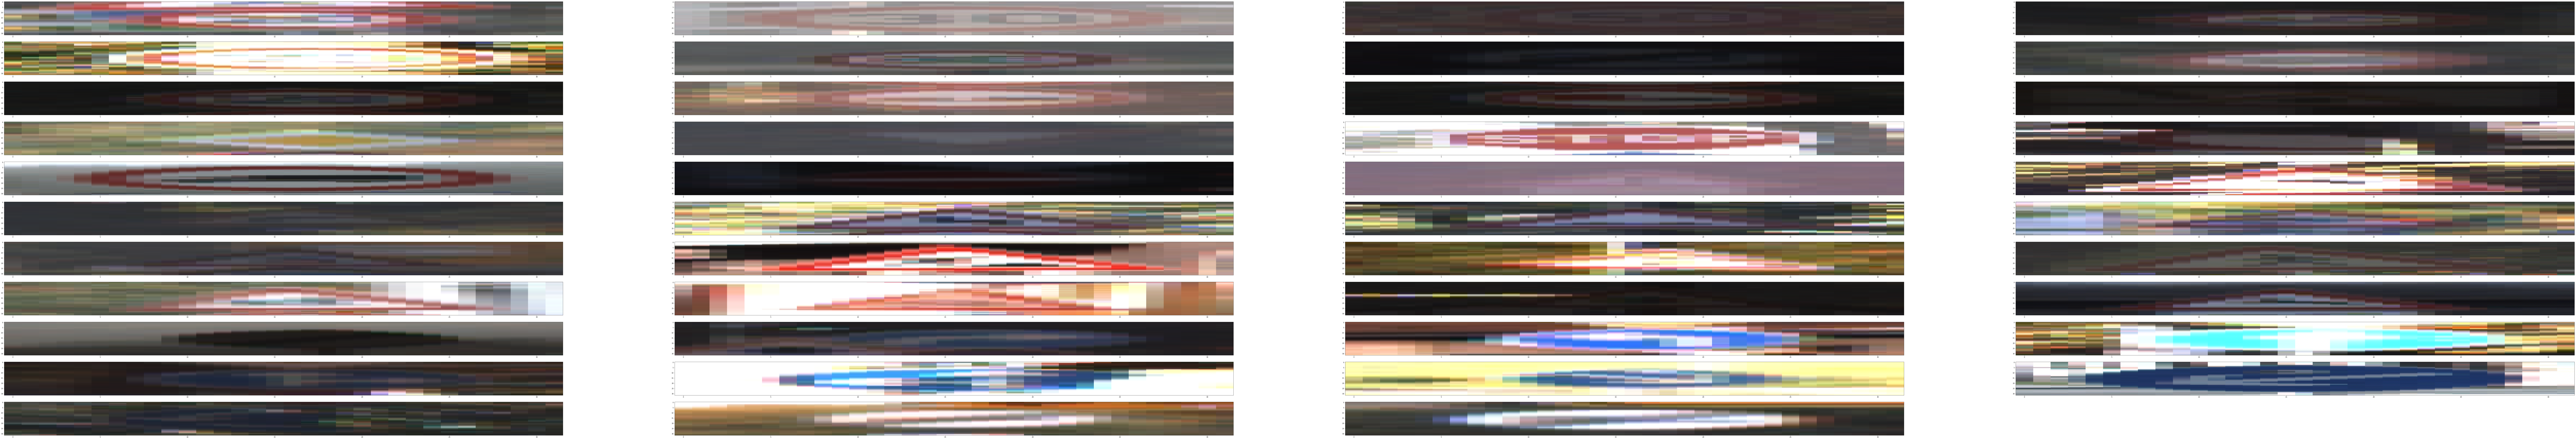

In [6]:
y = pd.DataFrame(y_train,columns=['label'])
y['value'] = y.index
ix = np.array(y.groupby('label').first())
ix = np.squeeze(ix)
X_sample = X_train[ix,:,:,:]
im_grid = X_sample.shape[0] // 2
plt.figure(figsize=(300,100))
for i in range(NB_CLASSES):
    plt.subplot(im_grid, 4, i+1)
    plt.imshow(X_sample[i], aspect='auto')

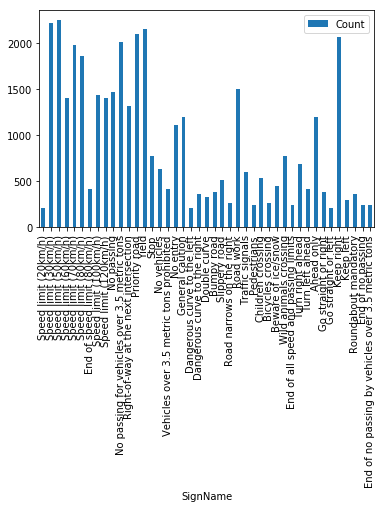

In [7]:
_y_dist = collections.Counter(y_train)
y_dist = pd.DataFrame.from_dict(_y_dist, orient='index').reset_index()
y_dist.columns = ['ClassId','Count']
y_dist = y_dist.merge(class_names, on='ClassId').drop('ClassId',axis=1)
y_dist.index = y_dist.SignName
plt.figure(figsize=(200,100))
y_dist.plot.bar()

In [8]:
y_classes =  y_dist.index.str.lower().tolist()
y_classes

['speed limit (20km/h)',
 'speed limit (30km/h)',
 'speed limit (50km/h)',
 'speed limit (60km/h)',
 'speed limit (70km/h)',
 'speed limit (80km/h)',
 'end of speed limit (80km/h)',
 'speed limit (100km/h)',
 'speed limit (120km/h)',
 'no passing',
 'no passing for vehicles over 3.5 metric tons',
 'right-of-way at the next intersection',
 'priority road',
 'yield',
 'stop',
 'no vehicles',
 'vehicles over 3.5 metric tons prohibited',
 'no entry',
 'general caution',
 'dangerous curve to the left',
 'dangerous curve to the right',
 'double curve',
 'bumpy road',
 'slippery road',
 'road narrows on the right',
 'road work',
 'traffic signals',
 'pedestrians',
 'children crossing',
 'bicycles crossing',
 'beware of ice/snow',
 'wild animals crossing',
 'end of all speed and passing limits',
 'turn right ahead',
 'turn left ahead',
 'ahead only',
 'go straight or right',
 'go straight or left',
 'keep right',
 'keep left',
 'roundabout mandatory',
 'end of no passing',
 'end of no passing 


## Preprocessing
The images are mean-substacted. Centering the input data around zero helps to allevaite dead or saturated neuron issues. I did not reduce the image to the gray-scale because it turns out that keeping the original three channel helps with the accuracy. This makes sense given that certain traffic signs have distinct colors associated with them. 

In addition, the main idea behind real-time data augmentation is to make the model more resistant to overfitting. By applying small distortions to the dataset, we implicitly force the model to memorize less and generalize better. 

What type of augmentions can we use for this problem? Upon inspection of the image classes and fitting the model on images generated through combinations of transformations, it turns out flipping the images upside-down or left-to-right is not such a great idea. Because when you flip a `go straight or right` sign, it actually becomes `go straight or left`. Smoothing the image did not help either, possibly the image size is very small to begin with.

I have found that randomly rotating the image confined to a certain degree, however, turns out to be a helpful augmentation technique. Distoring the brightness of the image seemed to also help slightly with validation accuracy.

tIn he code below, `ImageGenerator` acts as a generator by mean-substracting and applying random distortions to the input image. This in turn allows us to run batches that are not confined to number of training examples in the dataset.

The data is split into training and validation, using a 80-20 split.

In [9]:
# Image Generation. Inspired by Keras image generation logic.
class ImageGenerator():
    
    def __init__(self, batch_size, x, y):
        self.x = x
        self.y = y
        self.batch_index = 0
        self.batch_size = batch_size
        self.shift_degree = 22.5
        self.N = len(x)
        self.shape = (32, 32)
        self.index_generator = self._flow_index(self.N, batch_size, shuffle)
    
    # maintain the state
    def _flow_index(self, N, batch_size, shuffle=True):
        while 1:
            if self.batch_index == 0:
                index_array = np.arange(N)
            if shuffle:
                index_array = np.random.permutation(N)
                
            current_index = (self.batch_index * batch_size) % N
            if N >= current_index + batch_size:
                current_batch_size = batch_size
                self.batch_index += 1
            else:
                current_batch_size = N - current_index
                self.batch_index = 0
            yield (index_array[current_index: current_index + current_batch_size],
               current_index, current_batch_size) 
            
    def __iter__(self):
        return self
        
    def __next__(self):
        ix_array, current_index, current_batch_size = next(self.index_generator)
        batch_x = np.zeros(tuple([current_batch_size] + list(self.x.shape)[1:]))
        for i, j in enumerate(ix_array):
            x = self.x[j]
            x = self.transform(x)
            x = self.mean_substract(x)
            batch_x[i] = x
        batch_y = self.y[ix_array]
        return batch_x, batch_y
            
    def transform(self,x):
        #x = self.random_flip(x)
        #x = self.random_gaussian_blur(x)
        x = self.random_brightness(x)
        x = self.random_rotate(x)
        return x
                  
    def random_flip(self, x):
        if np.random.random() < 0.5:
            x = np.flipud(x)
        if np.random.random() < 0.5:
            x = np.fliplr(x)
        return x
    
    def random_rotate(self,x):
        # Rotation of an image for an angle theta is achieved by the transformation matrix of the form M
        # Rotate the image by a random magnitude centered around shift_degree
        random_degree = np.random.uniform(low=-1, high=1) * self.shift_degree
        M = cv2.getRotationMatrix2D((self.shape[0]/2,self.shape[1]/2),random_degree,1)
        return cv2.warpAffine(x,M,self.shape)
        
    def random_gaussian_blur(self, img, kernel_size=3):
        if np.random.random() < 0.5:
            return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)
        else:
            return img
    
    def random_brightness(self, img):
        image1 = cv2.cvtColor(img,cv2.COLOR_RGB2HSV)
        random_bright = np.random.uniform(low=0.5, high=1.5)
        image1[:,:,2] = image1[:,:,2] * random_bright
        image1 = cv2.cvtColor(image1,cv2.COLOR_HSV2RGB)
        return image1
    
    def mean_substract(self,img):
        return img - np.mean(img)

For completeness, I give examples of each transformation the generator is capable of. 

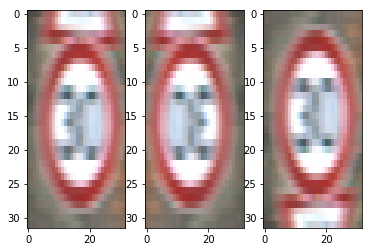

In [10]:
# Image-flippin
_ix = 990
x1 = np.fliplr(X_train[_ix])
x2 = np.flipud(X_train[_ix])
plt.subplot(1, 3, 1)
plt.imshow(X_train[_ix], aspect='auto')
plt.subplot(1, 3, 2)
plt.imshow(x1, aspect='auto')
plt.subplot(1, 3, 3)
plt.imshow(x2, aspect='auto')

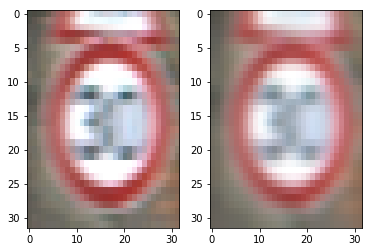

In [11]:
# Denoising applies a gaussian filter to smooth out the data
x1 = cv2.GaussianBlur(X_train[_ix], (3, 3), 0)
plt.subplot(1, 2, 1)
plt.imshow(X_train[_ix], aspect='auto')
plt.subplot(1, 2, 2)
plt.imshow(x1, aspect='auto')

0.7371054718861114


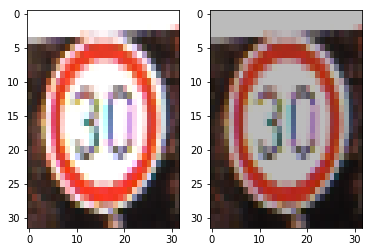

In [12]:
# Random Brightness adjustment
_ix = 399
image1 = cv2.cvtColor(X_train[_ix],cv2.COLOR_RGB2HSV)
random_bright = np.random.uniform(low=0, high=2)
print(random_bright)
image1[:,:,2] = image1[:,:,2] * random_bright
image1 = cv2.cvtColor(image1,cv2.COLOR_HSV2RGB)
               
plt.subplot(1, 2, 1)
plt.imshow(X_train[_ix], aspect='auto')
plt.subplot(1, 2, 2)
plt.imshow(image1, aspect='auto')

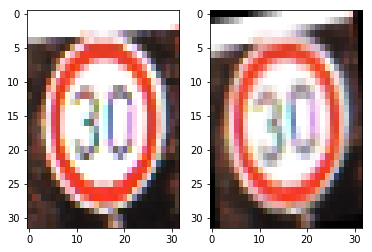

In [13]:
#Randomly Rotate Slightly
random_degree = np.random.uniform(low=-1, high=1) * 22.5
M = cv2.getRotationMatrix2D((32/2,32/2),random_degree,1)
image1 = cv2.warpAffine(X_train[_ix],M,(32,32))

plt.subplot(1, 2, 1)
plt.imshow(X_train[_ix], aspect='auto')
plt.subplot(1, 2, 2)
plt.imshow(image1, aspect='auto')

I split the data into training and validation, using a 80-20 split. 

In [14]:
train_test_split_ratio = 0.2
# Shuffle and split into validation / training
ix = list(range(n_train))
random.shuffle(ix)
X_train = X_train[ix,:]
y_train = y_train[ix]
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size= train_test_split_ratio , random_state=0)
print("the size of the training and validation data: {}, {}".format(X_train.shape[0], X_val.shape[0]))
NB_TRAIN_DATA = len(y_train)

the size of the training and validation data: 31367, 7842


I make sure that I normalize the image data for the validation and test set. 

In [15]:
def mean_substract(img):
    return img - np.mean(img)
    
X_val_normalized = mean_substract(X_val)
X_test_normalized = mean_substract(X_test)
X_val_normalized.shape

(7842, 32, 32, 3)

# Model Architechture



I built a 3 layer CNN achitechture with filter size _3x3_. I have chosen `AdamOptimizer` as the optimizer. `AdamOptimizer` combines the logic of `AdaGrad` optimizer with momentum. In short, `AdaGrad` keeps track of historical sums of squares in each gradient, which is used to normalize the immediate gradient update. Momentum, in turn, allows a velocity to build up - very much like in physics along gradients. 

The batch size is set to _128_. A larger batch size is more stable, but takes a longer time to run. I have iterated over synthetic dataset through _50_ epochs, which seems to be adaquate enough to get to a detect error / accuracy rate. I could have trained the model through more epochs in combiniation with an early-stopping mechanism. For each epoch, the data generator generates _50,000_ images randomly. The initial learning rate is set to _0.001_. The hyperparameters are mostly chosen by trial-and-error. One needs to be careful with peeking too much into the validation data however. The dirtier the validation set gets, the less meaningful it is as an out-of-sample accuracy proxy. 

Weights used in the convolutional layers were initialized using a truncated normal distribution with a standard deviation of _0.1_. Bias weights were either initialized to zeros or ones. Weights for the fully connected layers were initialized also using a truncated normal distribution with a standard deviation of _0.1_.

Image classes were transformed into one-hot encodings. A reduced mean, cross entropy loss function was fed the logits from the last fully connected layer.

I experimented with couple of regularization techniques such as L2 or batch normalization or dropout. The latter two did not offer any improvement over L2 norm on the fully-connected layers, so I did stick with L2 norm. 





| Layer | Description   |
|-------|---------------|
|   Input   | 32x32x3 RGB Image - Normalized and Randomly Perturbed|
|   Convolution 3x3   | 32 filters. Same padding. 1x1 stride|
|   RELU   | |
|   Max Pooling   | 2x2 stride, kernel size of 2x2|
|   Convolution 3x3   | 32 filters. Same padding. 1x1 stride|
|   RELU   | |
|   Max Pooling   | 2x2 stride, kernel size of 2x2|
|   Fully Connected Layer   | 128 hidden layers|
|   Fully Connected Layer   | Softmax Layer. 43 classes|




In [16]:
#Reset the graph
tf.reset_default_graph()
graph = tf.get_default_graph()
assert [] == graph.get_operations()

In [17]:
#  Models.
def convNet(data, one_hot_y, loss_beta = 0.01):
    # Variables.
    # For saving and optimizer. 
    global_step = tf.Variable(0, name="global_step")
    
    # conv weights
    layer1_weights = tf.Variable(tf.truncated_normal(
      [FILTER_SIZE, FILTER_SIZE, INPUT_CHANNELS, NB_FILTERS], stddev=0.1), name="layer1_weights")
    l2_layer1 = loss_beta * tf.nn.l2_loss(layer1_weights)
    
    layer1_biases = tf.Variable(tf.zeros([NB_FILTERS]), name="layer1_biases")
    layer2_weights = tf.Variable(tf.truncated_normal(
      [FILTER_SIZE, FILTER_SIZE, NB_FILTERS, NB_FILTERS], stddev=0.1), name="layer2_weights")
    l2_layer2 = loss_beta * tf.nn.l2_loss(layer2_weights)
    layer2_biases = tf.Variable(tf.constant(1.0, shape=[NB_FILTERS]), name="layer2_biases")

    # fully connected layers
    layer3_weights = tf.Variable(tf.truncated_normal(
      [IMAGE_SIZE // 4 * IMAGE_SIZE // 4 * NB_FILTERS, NB_HIDDEN], stddev=0.1), name="layer3_weights")
    layer3_biases = tf.Variable(tf.constant(1.0, shape=[NB_HIDDEN]), name="layer3_biases")
    layer4_weights = tf.Variable(tf.truncated_normal(
      [NB_HIDDEN, NB_CLASSES], stddev=0.1), name="layer4_weights")
    layer4_biases = tf.Variable(tf.constant(1.0, shape=[NB_CLASSES]), name="layer4_biases")
    
    # 1st Convolution
    conv = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='SAME')
    # Relu activation of conv
    hidden = tf.nn.relu(conv + layer1_biases)
    # Max pooling of activation
    hidden_pooled = tf.nn.max_pool(hidden, ksize = [1,2,2,1], strides = [1,2,2,1], padding='SAME')
    #print(hidden_pooled.get_shape())
    # 2nd Convolution
    conv = tf.nn.conv2d(hidden_pooled, layer2_weights, [1, 1, 1, 1], padding='SAME')
    # Relu activation of conv
    hidden = tf.nn.relu(conv + layer2_biases)
    # Max pooling
    hidden_pooled = tf.nn.max_pool(hidden, ksize = [1,2,2,1], strides = [1,2,2,1], padding='SAME')
    #print(hidden_pooled.get_shape())
    # Flatten
    shape = hidden_pooled.get_shape().as_list()
    reshape = tf.reshape(hidden_pooled, [-1, shape[1] * shape[2] * shape[3]])
    # 1st fully connected layer with relu activation
    #print(reshape.get_shape())
    hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
    # 2nd fully connected layer
    logits = tf.matmul(hidden, layer4_weights) + layer4_biases
    
    # loss
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
    loss_operation = tf.reduce_mean(cross_entropy)
    loss_operation += l2_layer1
    loss_operation += l2_layer2
    
    # accuracy
    correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
    accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    
    return logits, loss_operation, correct_prediction, accuracy_operation

print('done')

done


In [18]:
# Placeholders.
tf.reset_default_graph()
global_step = tf.Variable(0, name="global_step")
x = tf.placeholder(
    tf.float32, shape=(None, IMAGE_SIZE, IMAGE_SIZE, INPUT_CHANNELS),name='x')
y = tf.placeholder(tf.int32, shape=(None),name='y')
one_hot_y = tf.one_hot(y, NB_CLASSES)

In [19]:
# Set the graph computations.
logits, loss_operation, correct_prediction, accuracy_operation  = convNet(x, one_hot_y)
# cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
# loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = LR)
training_operation = optimizer.minimize(loss_operation)

Setting up the final ops and evaluation function for validation accuracy.

In [20]:
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

print('done')

done


In [21]:
gr = tf.get_default_graph()
print("Number of ops in TF Graph is {}".format(len(gr.get_operations())))

Number of ops in TF Graph is 485


This is where we finally train our model.

In [22]:
#Initiate the generator
gen = ImageGenerator(BATCH_SIZE, X_train, y_train)

In [23]:
model_path = base_image_path + checkpoint_name

In [24]:
tr_error_rate = []
vl_accuracy = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())    
    print("Training...")
    print()
    for i in range(NB_EPOCHS):
        print("Epoch {} ...".format(i+1))
        for offset in range(0, NB_TRAIN_SAMPLES, BATCH_SIZE):
            batch_x, batch_y = next(gen)
            _, l = sess.run([training_operation, loss_operation] , feed_dict={x: batch_x, y: batch_y})
        tr_error_rate.append(l)
        validation_accuracy = evaluate(X_val_normalized, y_val)
        vl_accuracy.append(validation_accuracy)
        print("Training Loss = {:.3f}".format(l))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    # Save the variables to disk.
    save_path = saver.save(sess, model_path)
    print("Model saved in file: %s" % model_path)
print('done')

Training...

Epoch 1 ...
Training Loss = 2.448
Validation Accuracy = 0.339

Epoch 2 ...
Training Loss = 1.446
Validation Accuracy = 0.549

Epoch 3 ...
Training Loss = 0.912
Validation Accuracy = 0.686

Epoch 4 ...
Training Loss = 0.669
Validation Accuracy = 0.824

Epoch 5 ...
Training Loss = 0.657
Validation Accuracy = 0.865

Epoch 6 ...
Training Loss = 0.346
Validation Accuracy = 0.863

Epoch 7 ...
Training Loss = 0.266
Validation Accuracy = 0.874

Epoch 8 ...
Training Loss = 0.303
Validation Accuracy = 0.901

Epoch 9 ...
Training Loss = 0.139
Validation Accuracy = 0.914

Epoch 10 ...
Training Loss = 0.242
Validation Accuracy = 0.920

Epoch 11 ...
Training Loss = 0.234
Validation Accuracy = 0.925

Epoch 12 ...
Training Loss = 0.255
Validation Accuracy = 0.939

Epoch 13 ...
Training Loss = 0.220
Validation Accuracy = 0.909

Epoch 14 ...
Training Loss = 0.255
Validation Accuracy = 0.914

Epoch 15 ...
Training Loss = 0.184
Validation Accuracy = 0.925

Epoch 16 ...
Training Loss = 0.180
V

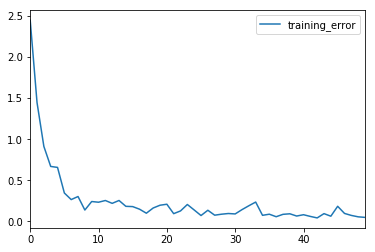

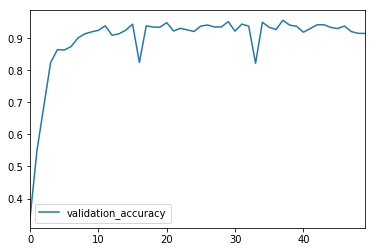

In [43]:

df = pd.DataFrame(np.array(tr_error_rate),columns=['training_error'])
df2 = pd.DataFrame(np.array(vl_accuracy),columns=['validation_accuracy'])

df.plot()
df2.plot()
# pd.DataFrame(np.array(vl_accuracy)).plot()


Next, I want to see if there are classes where my trained network is doing poorly. This is a bit of an iterative process. The reader only gets to see the final result of many iterations over the parameter hyperspace.

In [25]:
def predict(X_data):
    num_examples = len(X_data)
    predictions = []
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x = X_data[offset:offset+BATCH_SIZE]
        _predictions = sess.run(logits, feed_dict={x: batch_x})
        predictions.extend(_predictions)
    return np.array(predictions)

In [26]:
print(model_path)
#Test Predictions
with tf.Session() as sess:
    saver.restore(sess, model_path)
    print("Model Loaded...")
    predictions = predict(X_test_normalized)
print('done')

#Create a lookup for labels
class_names = class_names.drop('ClassId',axis=1)
lookup = class_names.to_dict()['SignName']

val_preds = [(lookup[np.argmax(p,0)], lookup[y]) for p,y in zip(predictions, y_test)]

val_preds = pd.DataFrame(val_preds,columns=['pred','truth'])
confusion_matrix = val_preds.groupby(['pred','truth']).size()
confusion_matrix = confusion_matrix.reset_index()
confusion_matrix.columns = val_preds.columns.tolist() + ['cnt']
confusion_matrix = confusion_matrix.pivot(index='pred', columns='truth', values='cnt').fillna(0)


traffic-signs-data/model.ckpt
Model Loaded...
done


In [70]:
nb_truth = np.array(confusion_matrix.sum(axis=0)).T
correct_pred = np.array(confusion_matrix).diagonal().T
false_pred = (nb_truth - correct_pred).T
false_pred.shape, correct_pred.shape, nb_truth.shape

((43,), (43,), (43,))

In [79]:
preds = pd.DataFrame({'ground_truth' : nb_truth, 'correct_pred': correct_pred, 'false_pred': false_pred})
preds.index = confusion_matrix.sum(axis=0).index
preds['accuracy'] = preds['correct_pred'] / preds['ground_truth']
preds.sort_values('accuracy')

,correct_pred,false_pred,ground_truth,accuracy
truth,,,,
Beware of ice/snow,32.0,118.0,150.0,0.213333
Road narrows on the right,20.0,70.0,90.0,0.222222
Children crossing,57.0,93.0,150.0,0.380000
Pedestrians,29.0,31.0,60.0,0.483333
Dangerous curve to the left,30.0,30.0,60.0,0.500000
Double curve,46.0,44.0,90.0,0.511111
Bumpy road,67.0,53.0,120.0,0.558333
Speed limit (20km/h),35.0,25.0,60.0,0.583333
General caution,238.0,152.0,390.0,0.610256


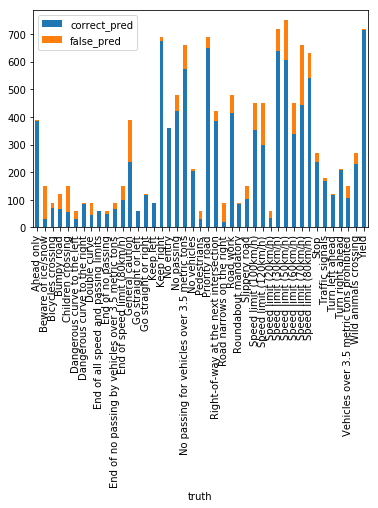

In [85]:
preds.drop(['ground_truth','accuracy'],axis=1).plot.bar(stacked=True)

Finally, after we are satisfied with all the tweaking, I took the test data out of the box and give it a whirl..

In [86]:
#Test Accuracy
with tf.Session() as sess:
    saver.restore(sess, model_path)
    print("Model Loaded...")
    test_accuracy = evaluate(X_test_normalized, y_test)
    print("Test Accuracy for Test Data = {:.3f}".format(test_accuracy))

Model Loaded...
Test Accuracy for Test Data = 0.831


The validation set accuracy is _0.915_, whereas the test set accuracy turned out to be _0.831_.  

I tried several architechtures including LeNet but ended up settling with a plain-vanilla ConvNet architecture because it led to a higher accuracy rate out of the box. The hyperparameter space is very very large even for a single model. Comparing multiple models adds to the complexity of the hand-tuning the parameters.

You can see the steps I have taken in terms of model parameters below. I decided to stick with the model that uses augmented data (random tilts) because I thought it would generate better on the training set. You can see above that the accuracy by class vary. In general, the model does not do a great job with the classes that has little data. Further iterations can alleviate this issue by fixing the class imbalance. Secondly, there are few classes with lot of data that we do poorly, including _General caution_, _Speed limit (70km/h)_, _Speed limit (120km/h)_, and _Speed limit (60km/h)_. Here too I might need more examples to discern similar looking speed limit signs. 

I can also always let the model run longer with more augmented data to see some improvements. 

---

## Test a Model on New Images

Now we apply the image classifier on images hat tI have found in the wild. 

In [138]:
import os
ground_truth = {'469763323.jpg': 'Roundabout mandatory', 
                '6a00d8341c083153ef00e553a89d7e8833-800wi.jpg':'Speed limit (60km/h)',
                'joachim_791251.jpg': 'Speed limit (80km/h)',
                'Schilderwald_in_Passau.jpg': 'Speed limit (30km/h)',
                '0.jpg': 'Speed limit (20km/h)',
                '186819557.jpg': 'Yield',
                '532135995.jpg': 'Priority road',
                '19.jpg': 'Wild animals crossing'
    }
image_names = os.listdir("street_signs/")
print(image_names)
processed_images = []
class_labels = []
for image_name in image_names:
    image = cv2.imread("street_signs/"+ image_name)
    class_labels.append(ground_truth[image_name])
    #preprocessing step. first crop then normalize
    resized = cv2.resize(image, (32,32), interpolation = cv2.INTER_AREA)
    wi = mean_substract(resized)
    processed_images.append(wi)

['0.jpg', '186819557.jpg', '19.jpg', '469763323.jpg', '532135995.jpg', '6a00d8341c083153ef00e553a89d7e8833-800wi.jpg', 'joachim_791251.jpg', 'Schilderwald_in_Passau.jpg']


In [139]:
# predict images in the wild
pred = []
with tf.Session() as sess:
    saver.restore(sess, model_path)
    print("Model Loaded...")
    _pred = predict(processed_images)

Model Loaded...


In [150]:
np.exp(_pred).sum(axis=1)

array([  1.85391749e-04,   1.26854405e+12,   1.82685462e+06,
         6.02538194e+12,   7.96407411e+15,   5.96930360e+18,
         1.68248188e+06,   4.48104130e+12], dtype=float32)

In [170]:
_v = np.exp(_pred).sum(axis=1)
softmax_probs = np.round(np.exp(_pred) / _v[:,None],2)

0


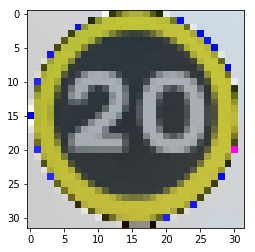

Label: Speed limit (20km/h)

Top 5 predictions:

SignName
Speed limit (80km/h)                                  1.0
End of no passing by vehicles over 3.5 metric tons    0.0
No passing for vehicles over 3.5 metric tons          0.0
General caution                                       0.0
No entry                                              0.0
Name: Speed limit (20km/h), dtype: float32
1


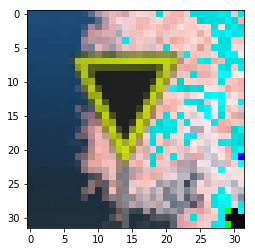

Label: Yield

Top 5 predictions:

SignName
Keep right                                            0.83
Go straight or right                                  0.14
Ahead only                                            0.03
End of no passing by vehicles over 3.5 metric tons    0.00
No passing                                            0.00
Name: Yield, dtype: float32
2


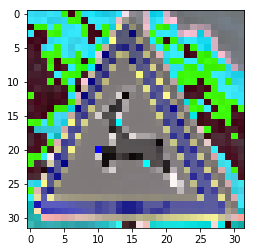

Label: Wild animals crossing

Top 5 predictions:

SignName
Wild animals crossing                       1.0
Dangerous curve to the right                0.0
General caution                             0.0
No entry                                    0.0
Vehicles over 3.5 metric tons prohibited    0.0
Name: Wild animals crossing, dtype: float32
3


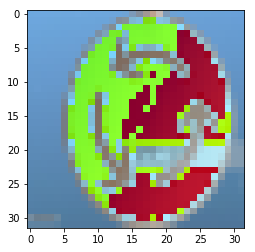

Label: Roundabout mandatory

Top 5 predictions:

SignName
Priority road                                         1.0
End of no passing by vehicles over 3.5 metric tons    0.0
No passing for vehicles over 3.5 metric tons          0.0
General caution                                       0.0
No entry                                              0.0
Name: Roundabout mandatory, dtype: float32
4


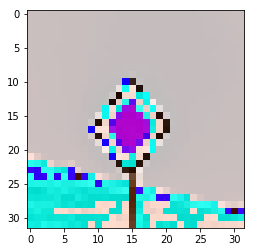

Label: Priority road

Top 5 predictions:

SignName
Speed limit (100km/h)                                 1.0
End of no passing by vehicles over 3.5 metric tons    0.0
No passing for vehicles over 3.5 metric tons          0.0
General caution                                       0.0
No entry                                              0.0
Name: Priority road, dtype: float32
5


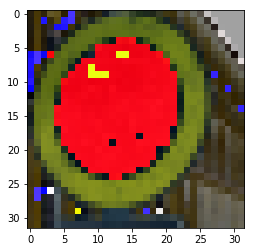

Label: Speed limit (60km/h)

Top 5 predictions:

SignName
Priority road                                         1.0
End of no passing by vehicles over 3.5 metric tons    0.0
No passing for vehicles over 3.5 metric tons          0.0
General caution                                       0.0
No entry                                              0.0
Name: Speed limit (60km/h), dtype: float32
6


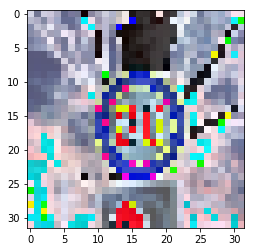

Label: Speed limit (80km/h)

Top 5 predictions:

SignName
Keep right                                            1.0
End of no passing by vehicles over 3.5 metric tons    0.0
No passing for vehicles over 3.5 metric tons          0.0
General caution                                       0.0
No entry                                              0.0
Name: Speed limit (80km/h), dtype: float32
7


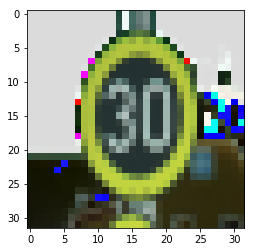

Label: Speed limit (30km/h)

Top 5 predictions:

SignName
Keep right                                            1.0
End of no passing by vehicles over 3.5 metric tons    0.0
No passing for vehicles over 3.5 metric tons          0.0
General caution                                       0.0
No entry                                              0.0
Name: Speed limit (30km/h), dtype: float32


In [188]:
import time
pred_wild = pd.DataFrame(softmax_probs,columns = class_names.SignName, index = class_labels )
for i, (lbl, pred) in enumerate(pred_wild.iterrows()):
    _pred = pred.sort_values(ascending=False).head(5)
    print(i)
    plt.imshow(processed_images[i])
    plt.show()
    print("Label: {}\n".format(lbl))
    print("Top 5 predictions:\n")
    print(_pred)
    print('='*10)
    

**Answer:**

In [ ]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

**Answer:**

**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.